<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Deterministic Creation of Multi-Qubit W State Systems

## _*Benchmarking Competing Algorithms by Quantum Tomography*_ 


***
### Contributors
Pierre Decoodt


A generalized $n$-qubit W state system can be written as$^{[1]}$:
$$ |W_{n}\rangle \; = \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |01...0\rangle \: +...+ |00...1\rangle \:) $$

A specific compact algorithm allows the deterministic creation of W states of any size $n$., as described here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/community/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb

This algorithm is inspired by Diker's theoretical proposition$^{[2]}$, but is characterized by a linear rather than quadratic progression of the number of gates needed when  $ n $ increases.

In many cases, the QISKit compiler is so smart that it allows safely the programming of circuits without taking into account the architecture of the different final real target devices. This is the approach that is presented here with realization of a compact multi-qubit W state generation program.

For the creation of such states, an other approach is to use a general algorithm of arbitrary initialization, as described _at the end_ of the following tutorial:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/terra/using_different_gates.ipynb


Therefore, why worry about using a specific algorithm, sophisticated on the theoretical level, while a ready-made alternative, valid for any entangled state, is at our disposal?

For this reason, it seemed interesting to compare the two approaches by using quantum fidelity as a benchmark, with the help of the methodology presented here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/ignis/state_tomography.ipynb (the code to calculate the quantum fidelity used here comes mostly from this last tutorial).

As you will see at the end of the notebook in the "results" section, one of the algorithms in competition clearly outperforms the other...

NB : This version for qiskit-terra 0.6 (QuantumProgram removed)

In [1]:
#Importing packages

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline


# importing from qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import Aer, IBMQ

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram        
from qiskit.tools.qi.qi import state_fidelity, outer
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer, qx_color_scheme 
%config InlineBackend.figure_format = 'png'

In [2]:
# You may skip this if you don't have a credential. It will work locally on simulators from Aer
IBMQ.load_accounts()

In [3]:
IBMQ.backends() #for info

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [4]:
# You may skip this if you want
for backend in IBMQ.backends():
    print(backend.status())

{'pending_jobs': 199, 'name': 'ibmqx4', 'operational': True}
{'pending_jobs': 8, 'name': 'ibmqx5', 'operational': False}
{'pending_jobs': 0, 'name': 'ibmqx2', 'operational': False}
{'pending_jobs': 1, 'name': 'ibmq_16_melbourne', 'operational': True}
{'pending_jobs': 0, 'name': 'ibmq_qasm_simulator', 'operational': True}


In [5]:
Aer.backends() #for info

[<QasmSimulator('qasm_simulator') from Aer()>,
 <QasmSimulatorPy('qasm_simulator_py') from Aer()>,
 <StatevectorSimulator('statevector_simulator') from Aer()>,
 <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>,
 <UnitarySimulator('unitary_simulator') from Aer()>,
 <CliffordSimulator('clifford_simulator') from Aer()>]

In [6]:
# Determining the job
n = int(input("type number of qubits + enter: "))

# Creating a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
my_state = QuantumCircuit(qr, cr, name='my_state')

# Desired vector for a n-qubit W state
desired_vector = []
qr_vector = []
n_vector = 2**n
for i in range(n_vector):
        desired_vector.append(0)
for j in range(n) :           
        desired_vector[2**j] = 1/np.sqrt(n)

        
# Choice of the circuit building method (arbitrary or specific)        
print("Do you want to use the specific method?")
W_state_circuit = input("    Answer by (y/n) + enter\n").upper()

if (W_state_circuit == "N") :
# Initializing a n-qubit W quantum state using the arbitrary method   
    for j in range(n) :                   
        qr_vector.append(qr[j])
    my_state.initialize(desired_vector, qr_vector)
    
else:
# Quantum circuit to make a n-qubit W state using the specific method
    my_state.x(qr[n-1]) #start is |10...0>
    for i in range(1,n) :
        theta = np.arccos(np.sqrt(1/(n-i+1)))
        my_state.ry(-theta,qr[n-i-1])       
        my_state.cz(qr[n-i],qr[n-i-1])
        my_state.ry(theta,qr[n-i-1])
    for i in range(1,n) :
        my_state.cx(qr[n-i-1],qr[n-i])

type number of qubits + enter: 3
Do you want to use the specific method?
    Answer by (y/n) + enter
y


In [7]:
#Test circuit "my_state"  : Measurements
measuring = QuantumCircuit(qr, cr, name='measuring')
for i in range(n) :
    measuring.measure(qr[i] , cr[i])
test = my_state+measuring

start executing test, specific: Y qubits: 3 backend: qasm_simulator shots: 1024 09/10/2018 16:55:41
<bound method AerJob.status of <qiskit.backends.aer.aerjob.AerJob object at 0x0000021861C64A20>>


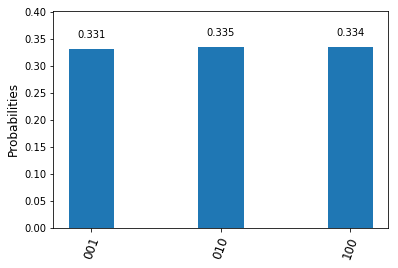

{'001': 339, '010': 343, '100': 342}


In [8]:
#Test circuit "my_state" : Local simulator
backend_sim = Aer.get_backend('qasm_simulator')
shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start executing test, specific:', W_state_circuit, "qubits:",n,'backend:',backend_sim, "shots:", shots,time_exp)
job = execute(test, backend_sim, shots=shots, max_credits=5)
print(job.status)
plot_histogram(job.result().get_counts(test))
print(job.result().get_counts(test))

In [11]:
# QASM from test
QASM_source = test.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
x q0[2];
ry(-0.955316618124509) q0[1];
cz q0[2],q0[1];
ry(0.955316618124509) q0[1];
ry(-0.785398163397448) q0[0];
cz q0[1],q0[0];
ry(0.785398163397448) q0[0];
cx q0[1],q0[2];
cx q0[0],q0[1];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];
measure q0[2] -> c0[2];



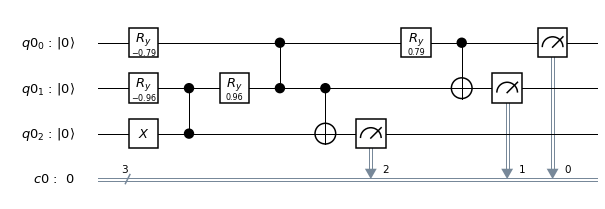

In [12]:
# Draw the circuit (At time of publishing for Qiskit 0.6.1, it doesn't work for arbitrary initialization circuit)
my_style = {'latexdrawerstyle': True, 'cregbundle': True}
if W_state_circuit == "Y" :
    drawer(test, style=my_style)

start executing test, specific: Y qubits: 3 backend: qasm_simulator shots: 1024 09/10/2018 16:56:11
<bound method IBMQJob.status of <qiskit.backends.ibmq.ibmqjob.IBMQJobPreQobj object at 0x00000218621F32B0>>


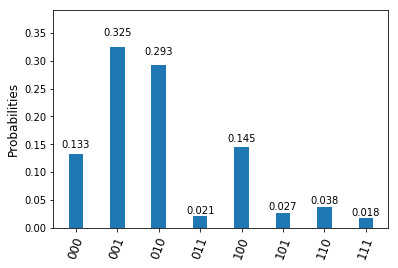

{'000': 136, '001': 333, '010': 300, '011': 22, '100': 148, '101': 28, '110': 39, '111': 18}


In [13]:
#Test circuit "my_state" : Real Quantum Computer (You may skip this if necessary)

#Choosing the backend
#backend_IBMQ = IBMQ.get_backend('ibmqx4') # for using this real device
backend_IBMQ = IBMQ.get_backend('ibmq_16_melbourne')
#backend_IBMQ = IBMQ.get_backend('ibmq_qasm_simulator') # if the real devices are too busy or as a final precautionary test
shots = 1024

time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start executing test, specific:', W_state_circuit, "qubits:",n,'backend:',backend_sim, "shots:", shots,time_exp)
job = execute(test, backend_IBMQ, shots=shots, max_credits=5)
print(job.status)
plot_histogram(job.result().get_counts(test))
print(job.result().get_counts(test))

In [16]:
# Quantum fidelity

# Obtaining the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# Construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# Add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

#Choosing the backend
#backend_tomo = IBMQ.get_backend('ibmqx4') # for using this real device
#backend_tomo = IBMQ.get_backend('ibmq_16_melbourne') # for using this real device
#backend_tomo = IBMQ.get_backend('ibmq_qasm_simulator') # if the real devices are too busy or as a final precautionary test
backend_tomo = Aer.get_backend('qasm_simulator') # for remaining local

# Take 1024 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 1024
# set max credits
max_credits = 4

# Run the experiment
my_state_job = execute(my_state_tomo_circuits, backend_tomo, shots=shots)
print(my_state_job.status)
my_state_tomo_result = my_state_job.result()

print(my_state_tomo_result)

# Extracting tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('my state',n, '- qubit on', backend_tomo, "N=", shots,time_exp)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with ideal state')
print('F =', F_fit)

<bound method IBMQJob.status of <qiskit.backends.ibmq.ibmqjob.IBMQJobPreQobj object at 0x00000218620FE7B8>>
COMPLETED
my state 3 - qubit on ibmq_16_melbourne N= 1024 09/10/2018 17:33:44
Fidelity with ideal state
F = 0.690766711127575


### Results: ###

The following results were obtained on the ibmqx4 using 1024 shots in each experiment:

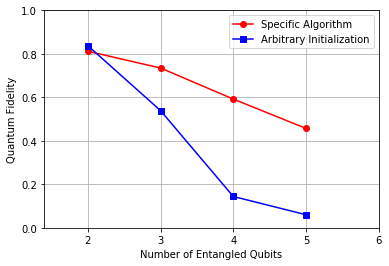

In [17]:
plt.xlabel('Number of Entangled Qubits')
plt.ylabel('Quantum Fidelity')
plt.axis([1.4, 6, 0, 1])
plt.grid()
plt.plot([2,3,4,5], [0.812,0.735,0.592,0.457], 'ro-', label="Specific Algorithm")
plt.plot([2,3,4,5], [0.838,0.539,0.144,0.060], 'bs-', label="Arbitrary Initialization")
plt.legend()
plt.show()

### Concluding remark:


The efficiency of the more compact specific algorithm as a deterministic $ |W_{n}\rangle$ production tool, when estimated from the quantum fidelity, is clearly related to the linear progression of the number of required gates when n increases. On the other hand, the arbitrary initialization requires a number of gate increasing geometrically.
This can be appreciated by looking at the qasm source of the respective circuits. 

### References:

[1] Dür, W., Vidal, G., & Cirac, J. I. (2000). Three qubits can be entangled in two inequivalent ways. Physical Review A, 62(6), 062314. 

[2] Diker, F. (2016). Deterministic construction of arbitrary W states with quadratically increasing number of two-qubit gates. arXiv preprint arXiv:1606.09290
